In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils
from gensim.models.ldamodel import LdaModel

In [3]:
sotu = pd.read_csv("http://cssbook.net/d/sotu.csv")
p_obama = sotu[sotu.President == "Obama"].text.str.split("\n\n").explode()
cv = CountVectorizer(min_df=.01, stop_words='english')
d = cv.fit_transform(p_obama)
d

<738x684 sparse matrix of type '<class 'numpy.int64'>'
	with 14396 stored elements in Compressed Sparse Row format>

In [4]:
corpus = matutils.Sparse2Corpus(d, documents_columns=False)
vocab = dict(enumerate(cv.get_feature_names()))

lda = LdaModel(corpus, num_topics=10, id2word=vocab, random_state=123, alpha='asymmetric')
pd.DataFrame({f"Topic {topicno}": [w for (w, tw) in words] 
              for (topicno, words) in lda.show_topics(formatted=False)})

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,america,american,year,people,america,energy,new,america,america,new
1,american,jobs,americans,new,time,jobs,years,americans,tax,jobs
2,people,years,know,ve,ve,people,make,hard,work,just
3,new,like,people,just,new,new,jobs,people,states,help
4,right,let,new,american,year,years,work,years,americans,country
5,world,ve,american,make,years,america,need,nation,businesses,families
6,help,americans,years,time,security,just,people,work,god,make
7,economy,people,like,care,change,work,let,ve,bless,world
8,let,year,ve,like,working,world,america,world,united,government
9,know,home,make,country,work,clean,economy,time,people,fact


In [5]:
topics = pd.DataFrame([dict(lda.get_document_topics(doc, minimum_probability=0.0))
                      for doc in corpus])
meta = sotu.iloc[p_obama.index].drop(columns=['text']).reset_index(drop=True)
tpd = pd.concat([meta, topics], axis=1)
tpd.head()

,FirstName,President,Date,delivery,type,party,0,1,2,3,4,5,6,7,8,9
0,Barack,Obama,2009-02-24,spoken,other,Democratic,0.022992,0.905655,0.013877,0.011605,0.009984,0.008761,0.007804,0.007036,0.006406,0.005879
1,Barack,Obama,2009-02-24,spoken,other,Democratic,0.017557,0.012980,0.010400,0.008707,0.007489,0.922522,0.005853,0.005277,0.004805,0.004410
2,Barack,Obama,2009-02-24,spoken,other,Democratic,0.516337,0.005989,0.254523,0.207272,0.003456,0.003033,0.002702,0.002436,0.002218,0.002035
3,Barack,Obama,2009-02-24,spoken,other,Democratic,0.946834,0.010359,0.008321,0.006964,0.005991,0.005256,0.004683,0.004222,0.003844,0.003528
4,Barack,Obama,2009-02-24,spoken,other,Democratic,0.008808,0.006493,0.005202,0.962295,0.003744,0.003285,0.002927,0.002639,0.002402,0.002205


In [6]:
for docid in [622, 11, 322]:
    print(f"{docid}: {list(p_obama)[docid]}")

622: I intend to protect a free and open Internet, extend its reach to every classroom and every community and help folks build the fastest networks so that the next generation of digital innovators and entrepreneurs have the platform to keep reshaping our world. I want Americans to win the race for the kinds of discoveries that unleash new jobs: converting sunlight into liquid fuel; creating revolutionary prosthetics so that a veteran who gave his arms for his country can play catch with his kids again; pushing out into the solar system not just to visit, but to stay. Last month, we launched a new spacecraft as part of a reenergized space program that will send American astronauts to Mars. And in 2 months, to prepare us for those missions, Scott Kelly will begin a year-long stay in space. So good luck, Captain. Make sure to Instagram it. We're proud of you.
11: Because of this plan, there are teachers who can now keep their jobs and educate our kids, health care professionals can cont

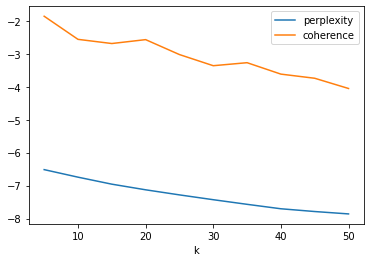

In [17]:
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

result = []
for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    lda = LdaModel(corpus, num_topics=k, id2word=vocab, random_state=123, alpha='asymmetric')
    perplexity = lda.log_perplexity(corpus)
    coherence = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass').get_coherence()
    result.append(dict(k=k, perplexity=perplexity, coherence=coherence))

result = pd.DataFrame(result)
result.plot(x="k", y=["perplexity", "coherence"])
plt.show()